In [1]:
#import required packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
import numpy as np
from sklearn.metrics import f1_score,classification_report, confusion_matrix,precision_score, recall_score
from tensorflow import keras

In [2]:
#post data
df = pd.read_csv('processed_data/labled_data.csv',usecols=['post','compulsion','obs-com','obsession'])
df.head()

,post,compulsion,obs-com,obsession
0,Hi -\nSo I haven't been on here since December...,0,0,1
1,"Hi all, hope you're all having a wonderful ban...",1,1,1
2,"Hi, \nFirst, I hope everyone managed to have s...",0,0,1
3,Hello everyone. I could really use your help r...,0,0,1
4,"Though it comes in many flavors, one of the mo...",1,1,1


# **Data Preparation**

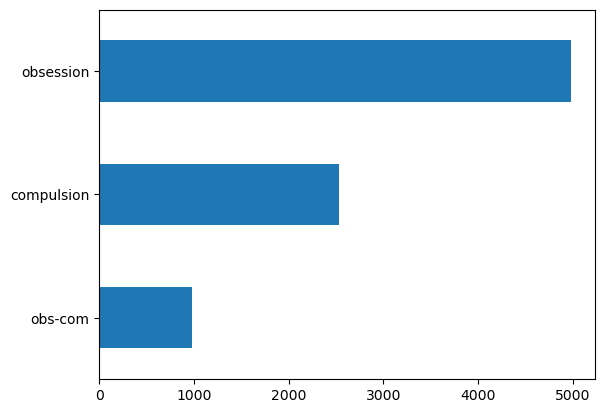

In [3]:
#print the number of post in each ensemble for each class(test data)
LABEL_COLUMNS = df.columns.tolist()[1:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

In [4]:
import re
#define the process of text cleaning
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r' ',text)
#Clean Text
def clean_text(data):
    # convert catacter to lowercase
    data['clean_text']=data['post'].str.lower()
    #remove URLS
    data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r"http\S+", "", elem))
    #remove ponctuation
    data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r"[^\w\s]", "", elem))
    #remove
    data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r'/n',"",elem))
    #remove degits
    data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r'\d+',"",elem))
    #remove emojis
    data['clean_text'] = data['clean_text'].apply(lambda elem:deEmojify(elem))
    #remove multiple spaces
    data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r'\s+'," ",elem))
    #remove single caracter
    data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r'\s+[a-zA-Z]\s+'," ",elem))
    return data

In [5]:
#apply the process of cleaning for the train and test data
df = clean_text(df)

In [6]:
#for the text pre-processing (text cleaning)
import nltk
nltk.download('punkt')
import re #regular expression
import string
from nltk.tokenize import word_tokenize # word tokenization
from nltk.stem import PorterStemmer # word stemming

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def remove_stop_words(text):
  stopW=stopwords.words('english')
  s=""
  for i in text.split():
    if i not in stopW:
        s=s+i+" "
  return s

In [9]:
df['clean_text']=df['clean_text'].apply(lambda x:remove_stop_words(x))

In [10]:
def stem(ch):
  stem = PorterStemmer()
  return " ".join([stem.stem(i) for i in ch.split()])

#apply the stem function to each row in the dataframe
df['clean_text'] = df['clean_text'].apply(lambda x:stem(x))

In [11]:
X, Y = df['clean_text'], df[['compulsion','obsession']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [12]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5235,), (5235, 2), (1309,), (1309, 2))

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
vect=Tokenizer()
vect.fit_on_texts(X_train)
vocab_size = len(vect.word_index) + 1
print(vocab_size)

20555


In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
encoded_docs_train = vect.texts_to_sequences(X_train)
MAX_LEN = 100
padded_docs_train = pad_sequences(encoded_docs_train, maxlen=MAX_LEN, padding='post')
print(padded_docs_train)

[[  25  608  192 ...  266  515  151]
 [  70  144  299 ...    0    0    0]
 [  88  251  183 ...    0    0    0]
 ...
 [  92  997   23 ...    0    0    0]
 [  63 1132 1684 ... 3962   66 4223]
 [   3    6  144 ...    0    0    0]]


In [15]:
encoded_docs_test =  vect.texts_to_sequences(X_test)
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=MAX_LEN, padding='post')

In [16]:
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

In [17]:
model = Sequential()
# Configuring the parameters
model.add(Embedding(vocab_size, output_dim=8, input_length=MAX_LEN))
model.add(LSTM(8, return_sequences=True))  
# Adding a dropout layer
model.add(Dropout(0.5))
model.add(LSTM(8))
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(2, activation='sigmoid'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 8)            164440    
                                                                 
 lstm (LSTM)                 (None, 100, 8)            544       
                                                                 
 dropout (Dropout)           (None, 100, 8)            0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 2)                 18        
                                                                 
Total params: 165,546
Trainable params: 165,546
Non-trai

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(padded_docs_train, y_train, epochs=1000, batch_size=16,validation_split=0.2,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',patience=20, min_delta=1e-7),
                              keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=10),
                              keras.callbacks.ModelCheckpoint(filepath='model/lstm_model.h5', 
                                      monitor='val_loss', 
                                      save_best_only=True)])

Epoch 1/1000
262/262 [==============================] - 12s 37ms/step - loss: 0.6352 - acc: 0.6089 - val_loss: 0.6116 - val_acc: 0.5998 - lr: 0.0010
Epoch 2/1000
262/262 [==============================] - 9s 35ms/step - loss: 0.6070 - acc: 0.6082 - val_loss: 0.6203 - val_acc: 0.5998 - lr: 0.0010
Epoch 3/1000
262/262 [==============================] - 10s 38ms/step - loss: 0.5113 - acc: 0.6917 - val_loss: 0.4751 - val_acc: 0.7545 - lr: 0.0010
Epoch 4/1000
262/262 [==============================] - 9s 36ms/step - loss: 0.3953 - acc: 0.8312 - val_loss: 0.4442 - val_acc: 0.7765 - lr: 0.0010
Epoch 5/1000
262/262 [==============================] - 9s 35ms/step - loss: 0.3189 - acc: 0.8799 - val_loss: 0.4554 - val_acc: 0.7851 - lr: 0.0010
Epoch 6/1000
262/262 [==============================] - 9s 36ms/step - loss: 0.2745 - acc: 0.9047 - val_loss: 0.4050 - val_acc: 0.7985 - lr: 0.0010
Epoch 7/1000
262/262 [==============================] - 9s 35ms/step - loss: 0.2483 - acc: 0.9088 - val_loss: 

In [19]:
predictions=model.predict([padded_docs_test])
thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for val in thresholds:
    pred=predictions.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_test, pred, average='micro')
    recall = recall_score(y_test, pred, average='micro')
    f1 = f1_score(y_test, pred, average='micro')
   
    print("Micro-average quality numbers for threshold", val)
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

41/41 [==============================] - 1s 6ms/step
Micro-average quality numbers for threshold 0.1
Precision: 0.8098, Recall: 0.9147, F1-measure: 0.8591
Micro-average quality numbers for threshold 0.2
Precision: 0.8183, Recall: 0.9048, F1-measure: 0.8594
Micro-average quality numbers for threshold 0.3
Precision: 0.8205, Recall: 0.9002, F1-measure: 0.8585
Micro-average quality numbers for threshold 0.4
Precision: 0.8213, Recall: 0.8962, F1-measure: 0.8571
Micro-average quality numbers for threshold 0.5
Precision: 0.8225, Recall: 0.8942, F1-measure: 0.8569
Micro-average quality numbers for threshold 0.6
Precision: 0.8241, Recall: 0.8890, F1-measure: 0.8553
Micro-average quality numbers for threshold 0.7
Precision: 0.8280, Recall: 0.8876, F1-measure: 0.8568
Micro-average quality numbers for threshold 0.8
Precision: 0.8330, Recall: 0.8804, F1-measure: 0.8560
Micro-average quality numbers for threshold 0.9
Precision: 0.8443, Recall: 0.8566, F1-measure: 0.8504


In [20]:
y_test[:10], predictions[:10]

(      compulsion  obsession
 1277           1          1
 4982           1          1
 1022           0          1
 5835           0          1
 1675           0          1
 2137           1          0
 48             1          1
 751            0          1
 1106           1          0
 3680           1          0,
 array([[0.995558  , 0.29322684],
        [0.00270869, 0.9995541 ],
        [0.0019342 , 0.9996596 ],
        [0.0018913 , 0.99966586],
        [0.97111917, 0.95039743],
        [0.9979401 , 0.04635631],
        [0.92226934, 0.97536045],
        [0.00189215, 0.99966574],
        [0.00195244, 0.9996566 ],
        [0.9982056 , 0.03724323]], dtype=float32))

In [21]:
Y_test = y_test.copy()
Y_test['compulsion_pred'] = predictions[:, 0]
Y_test['obsession_pred'] = predictions[:, 1]

In [22]:
Y_test[:20]

,compulsion,obsession,compulsion_pred,obsession_pred
1277,1,1,0.995558,0.293227
4982,1,1,0.002709,0.999554
1022,0,1,0.001934,0.999660
5835,0,1,0.001891,0.999666
1675,0,1,0.971119,0.950397
2137,1,0,0.997940,0.046356
48,1,1,0.922269,0.975360
751,0,1,0.001892,0.999666
1106,1,0,0.001952,0.999657
3680,1,0,0.998206,0.037243


In [23]:
model.save('model/lstm_model.h5')

In [24]:
import pickle
with open('model/lstm_tockenizer.pkl', 'wb') as f:
    pickle.dump(vect, f)